# CROC-CARIB12-Default -> Full Resolution Bathymetry
## Regional CESM-MOM6 for Caribbean with Default CrocoDash Grids and Inputs

This notebook is working off of a basic version of CARIB12 (Seijo-Ellis et al. 2024). The goal of this first test is to run the same domain over a short time period from January 1st, 2000 to January 5th, 2000 and compare with CARIB12. We are using the same grids and resolution, but the topography, CESM version, and tidal data are the different. This also uses the built in CrocoDash feature to generate a custom script to fetch glorys data using the copernicusmarine CLI; this should be the same as Gio's data (need to verify).

## Generate Regional MOM6 Domain

### Horizontal Grid

In [1]:
from CrocoDash.grid import Grid

grid = Grid.from_supergrid('/glade/work/ajanney/CaribCrocoDash/CrocCarib_Gio_Input/carib_012_hgrid.nc')
grid.name = 'CrocCaribGio_CESM3_0_beta06'

## Bathymetry
The Full GEBCO Data is so large that it needs to be processed in parallel using mpi

In [2]:
## Manually added a method `setup_bathymetry_mpi` to topo.py and added some optional args to rmom6 `setup_bathymetry()` accordingly
from CrocoDash.topo import Topo

topo = Topo.from_topo_file(grid, 
                           topo_file_path='/glade/work/ajanney/CaribCrocoDash/CrocCarib_Gio_Input/topo.carib_012v1.SRTM15_V2.4.SmL2.0_C2.0_edited_v3.nc', 
                           min_depth=9.5)

In [ ]:
'''
## After already interpolating, more efficient to just load it in
topo = Topo.from_topo_file(
    grid = grid,
    topo_file_path='/glade/work/ajanney/CrocoDash_Input/CrocCaribDefault_Coarse/ocnice/ocean_topog_CrocCaribDefault_4c66c5.nc',
    min_depth=10 # meters
    )
'''

In [6]:
# Erase Pacific & Canada Bays
%matplotlib ipympl

from CrocoDash.topo_editor import TopoEditor
topo.depth["units"] = "m"
TopoEditor(topo)

TopoEditor(children=(VBox(children=(HTML(value='<h2>Topo Editor</h2>'), HTML(value='<hr><h3>Display</h3>'), To…

<Figure size 1280x960 with 0 Axes>

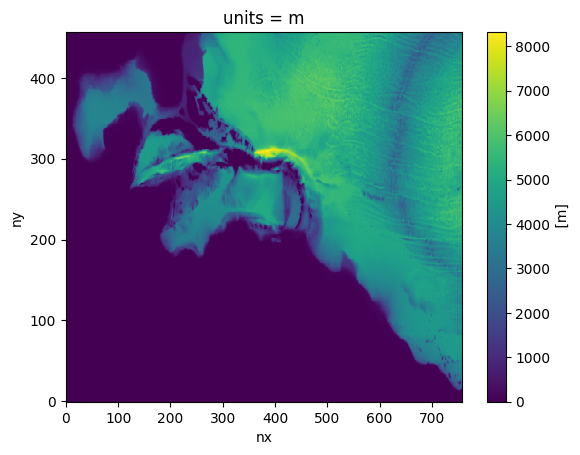

In [7]:
## Check bathymetry again after edits
import matplotlib.pyplot as plt

%matplotlib inline
plt.clf()
plt.figure()
topo.depth.plot()

## Vertical Grid

In [3]:
from CrocoDash.vgrid import VGrid

vgrid  = VGrid.from_file('/glade/work/ajanney/CaribCrocoDash/CrocCarib_Gio_Input/vgrid_65L_20200626.nc')

In [4]:
import numpy as np
print(vgrid.dz)
plt.plot(vgrid.dz,-np.cumsum(vgrid.dz),'o-')

[  2.5    2.5    2.5    2.5    2.77   3.38   4.01   4.65   5.29   5.95
   6.61   7.28   7.97   8.66   9.37  10.08  10.81  11.54  12.29  13.06
  13.85  14.69  15.59  16.56  17.61  18.76  20.02  21.42  23.    24.77
  26.79  29.1   31.76  34.87  38.5   42.79  47.9   54.01  61.37  70.25
  80.95  93.75 108.8  126.04 145.04 164.81 184.05 201.34 215.66 226.64
 234.5  239.84 243.31 245.52 246.88 247.72 248.23 248.54 248.73 248.84
 248.64 248.68 248.71 248.72 248.73]


NameError: name 'plt' is not defined

## Creating the CESM Case

In [4]:
from pathlib import Path

# CESM case (experiment) name
casename = "CrocCaribGio_CESM3_0_beta06"

# CESM source root (Update this path accordingly!!!)
cesmroot = '/glade/work/ajanney/CESM-versions/ESCOMP_CESM' # Path.home() / "cesm3_0_beta04"
# I grabbed this version from Alper

# Place where all your input files go 
inputdir = Path("/glade/work/ajanney/CrocoDash_Input",casename) # Path.home() / "croc_input" / casename
    
# CESM case directory
caseroot = Path("/glade/work/ajanney/CESM/cases",casename) # Path.home() / "croc_cases" / casename

In [5]:
from CrocoDash.case import Case

case = Case(
    cesmroot = cesmroot,
    caseroot = caseroot,
    inputdir = inputdir,
    ocn_grid = grid,
    ocn_vgrid = vgrid,
    ocn_topo = topo,
    project = 'P93300012', # also can be unspecified if set by user config e.g. export PBS_ACCOUNT=P93300012
    override = True,
)

CIMEError: ERROR: Command: '/glade/work/ajanney/conda-envs/CrocoDash/bin/xmllint --xinclude --noout --schema /glade/work/ajanney/CESM-versions/ESCOMP_CESM/cime/CIME/data/config/xml_schemas/entry_id.xsd /glade/work/ajanney/CESM-versions/ESCOMP_CESM/components/cmeps/cime_config/config_component.xml' failed with error '/glade/work/ajanney/CESM-versions/ESCOMP_CESM/components/cmeps/cime_config/config_component.xml:819: Schemas validity error : Element 'valid_values', attribute 'MACH': The attribute 'MACH' is not allowed.
/glade/work/ajanney/CESM-versions/ESCOMP_CESM/components/cmeps/cime_config/config_component.xml fails to validate' from dir '/glade/work/ajanney/CaribCrocoDash/test_notebooks'

## Might still need to figure out some xmlchanges to run